# 变分量子线路

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.2/mindquantum/zh_cn/mindspore_parameterized_quantum_circuit.ipynb)&emsp;
[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.2/mindquantum/zh_cn/mindspore_parameterized_quantum_circuit.py)&emsp;
[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.2/docs/mindquantum/docs/source_zh_cn/parameterized_quantum_circuit.ipynb)&emsp;
[![在ModelArts平台运行](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/resource/_static/logo_modelarts.svg)](https://authoring-modelarts-cnnorth4.huaweicloud.com/console/lab?share-url-b64=aHR0cHM6Ly9taW5kc3BvcmUtd2Vic2l0ZS5vYnMuY24tbm9ydGgtNC5teWh1YXdlaWNsb3VkLmNvbS9ub3RlYm9vay9yMi4yL21pbmRxdWFudHVtL3poX2NuL21pbmRzcG9yZV9wYXJhbWV0ZXJpemVkX3F1YW50dW1fY2lyY3VpdC5pcHluYg%3D%3D&imageid=c8303381-a19d-453c-b3c2-4c03de5025de)

## 概述

变分量子线路（Parameterized Quantum Circuit, PQC）即由含参数的量子门组成的量子线路，是进行量子机器学习的途径之一。在很多情况下，为了能与经典机器学习中神经网络进行类比，我们也经常会把变分量子线路称为量子神经网络。量子-经典混合计算架构MindSpore Quantum能够处理此类变分量子线路，并利用量子神经网络的可逆性对该线路进行自动微分，最后通过测量得到的观测值，即可计算出观测值对于各参数的导数。

构建PQC并用PQC模拟器算子对量子线路进行演化的大致流程如下：

- Step 1 初始化量子线路；

- Step 2 在量子线路中加入所需的含参量子门或者不含参量子门；

- Step 3 利用PQC模拟器算子进行态演化或者梯度求解。

## 环境准备

导入本教程所依赖的模块。

In [1]:
import numpy as np                                          # 导入numpy库并简写为np
from mindquantum.core.gates import X, Y, Z, H, RX, RY, RZ   # 导入量子门H, X, Y, Z, RX, RY, RZ

说明：

（1）numpy是一个功能强大的Python库，主要用于对多维数组执行计算，支持大量的维度数组与矩阵运算，此外也针对数组运算提供大量的数学函数库；

（2）mindquantum是量子-经典混合计算框架，支持多种量子神经网络的训练和推理；

（3）搭建的量子线路中所需执行的量子门需要从mindquantum.core模块中导入；

## 量子门

量子门（量子逻辑门）是对量子比特进行操作的基本逻辑单元，是量子线路的基础。对于经典电路来说，任意的逻辑电路都可以由一系列基本逻辑门构成，类似地，任意的量子线路也可以由一系列基本量子门构成，如单量子比特门和受控非门。常用的基本量子门有`X`门、`Y`门、`Z`门、`Hadamard`门（`H`门）、`CNOT`门以及旋转门`RX`门、`RY`门和`RZ`门。

一般来说，量子门可以分为含参量子门和不含参量子门。例如，不含参的量子门有`X`门、`Y`门、`Z`门、`Hadamard`门（`H`门）和`CNOT`门，它们的矩阵形式分别如下：

$$
\text{X}=
\left(
    \begin{matrix}
        0&1\\
        1&0
    \end{matrix}
\right),
\text{Y}=
\left(
    \begin{matrix}
        0&-i\\
        i&0
    \end{matrix}
\right),
\text{Z}=
\left(
    \begin{matrix}
        1&0\\
        0&-1
    \end{matrix}
\right),
\text{H}=\frac{1}{\sqrt{2}}
\left(
    \begin{matrix}
        1&1\\
        1&-1
    \end{matrix}
\right),
\text{CNOT}=
\left(
    \begin{matrix}
        1&0&0&0\\
        0&1&0&0\\
        0&0&0&1\\
        0&0&1&0
    \end{matrix}
\right).
$$

分别打印上述量子门的矩阵形式，可以得到：


In [2]:
print('Gate name:', X)
X.matrix()

Gate name: X


array([[0, 1],
       [1, 0]])

In [3]:
print('Gate name:', Y)
Y.matrix()

Gate name: Y


array([[ 0.+0.j, -0.-1.j],
       [ 0.+1.j,  0.+0.j]])

说明：矩阵里的每一项，左边的“0.”表示小数形式（浮点数）的实部（若实部为负，则在小数前显示“-”，否则默认为非负），右边的“0.”表示小数形式（浮点数）的虚部（若虚部为负，则在小数前会显示“-”，否则显示“+”），j表示虚数单位$i$。

In [4]:
print('Gate name:', Z)
Z.matrix()

Gate name: Z


array([[ 1,  0],
       [ 0, -1]])

In [5]:
print('Gate name:', H)
H.matrix()

Gate name: H


array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])

对于`CNOT`门，其本质上是受控`X`门（`Controlled-X` gate），因此在MindSpore Quantum中，如果我们需要执行`CNOT`门，只需设定`X`门的控制比特位和目标比特位即可（实际上，任意的量子门我们都可以设定控制比特位和所需执行量子门操作的目标比特位）。例如：

In [6]:
cnot = X.on(0, 1)   # X门作用在第0位量子比特且受第1位量子比特控制
print(cnot)

X(0 <-: 1)


说明：

（1）X(0 <-: 1) ，表示第0位量子比特位为目标比特位，第1位量子比特位为控制比特位，第0位量子比特受第1位量子比特控制，若第1位量子比特为1，则对第0位量子比特执行`X`门操作，否则不作任何操作；

上面介绍了一些常用的不含参量子门，接下来，我们将介绍一些含参量子门（如旋转门`RX`门、`RY`门和`RZ`门），通过赋予旋转角度$\theta$某些确定的值，可以得到作用不同的旋转门。另外，这些含参量子门是后续搭建量子神经网络的重要组成单元。

例如，`RX`门、`RY`门和`RZ`门的矩阵形式如下：

$$
\text{RX}(\theta)= e^{-\frac{i\theta X}{2}}=\cos\left(\frac{\theta}{2}\right)\cdot I-i\sin\left(\frac{\theta}{2}\right)\cdot X=
\left(
    \begin{matrix}
        \cos\left(\frac{\theta}{2}\right)&-i\sin\left(\frac{\theta}{2}\right)\\
        -i\sin\left(\frac{\theta}{2}\right)&\cos\left(\frac{\theta}{2}\right)
    \end{matrix}
\right),
$$

$$
\text{RY}(\theta)= e^{-\frac{i\theta Y}{2}}=\cos\left(\frac{\theta}{2}\right)\cdot I-i\sin\left(\frac{\theta}{2}\right)\cdot Y=
\left(
    \begin{matrix}
        \cos\left(\frac{\theta}{2}\right)&-\sin\left(\frac{\theta}{2}\right)\\
        \sin\left(\frac{\theta}{2}\right)&\cos\left(\frac{\theta}{2}\right)
    \end{matrix}
\right),
$$

$$
\text{RZ}(\theta)= e^{-\frac{i\theta Z}{2}}=\cos\left(\frac{\theta}{2}\right)\cdot I-i\sin\left(\frac{\theta}{2}\right)\cdot Z=
\left(
    \begin{matrix}
        e^{-\frac{i\theta}{2}}&0\\
        0&e^{\frac{i\theta}{2}}
    \end{matrix}
\right).
$$

我们令$\theta$分别为$0$和$\pi$，然后打印$\text{RX}(0)$门、$\text{RY}(\pi)$门和$\text{RZ}(\pi)$门的矩阵形式，可以得到：

In [7]:
rx = RX('theta')
print('Gate name:', rx)
rx.matrix({'theta': 0})   # 赋予theta的值为0

Gate name: RX(theta)


array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

当$\theta=0$时，此时$\text{RX}(0)$门就是我们熟悉的`I`门。

In [8]:
ry = RY('theta')
print('Gate name:', ry)
np.round(ry.matrix({'theta': np.pi}))   # pi需要从np中导入，赋予theta的值为pi。

Gate name: RY(theta)


array([[ 0.+0.j, -1.+0.j],
       [ 1.+0.j,  0.+0.j]])

当$\theta=\pi$时，此时$\text{RY}(\pi)$门就是我们熟悉的`Y`门。（相差一个全局相位$i$）

In [9]:
rz = RZ('theta')
print('Gate name:', rz)
np.round(rz.matrix({'theta': np.pi}))   # 赋予theta的值为pi，由于计算机中存在浮点数不精确的问题，因此通过函数np.round返回浮点数的四舍五入值。

Gate name: RZ(theta)


array([[0.-1.j, 0.+0.j],
       [0.+0.j, 0.+1.j]])

当$\theta=\pi$时，此时$\text{RZ}(\pi)$门就是我们熟悉的`Z`门。（相差一个全局相位$-i$）

## 量子线路

量子线路（也称量子逻辑电路）是最常用的通用量子计算模型，表示在抽象概念下，对于量子比特进行操作的线路。类比于经典线路，我们可以把一系列的量子逻辑门进行精心的设计组合，构成一个量子线路并完成一定的任务。例如，我们构建如下图所示的量子线路，该量子线路由三个量子门构成，分别是作用在$q_0$比特上的`H`门，作用在$q_0$和$q_1$比特上的`CNOT`门（即作用在$q_1$比特上且受$q_0$比特控制的`X`门）和作用在$q_2$比特上的$\text{RY}(\theta)$门。

![quantum circuit](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.2/docs/mindquantum/docs/source_zh_cn/images/quantum_circuit.png)

通过在量子线路中添加作用在不同量子比特位上的量子门即可快速完成对量子线路的搭建。

In [10]:
from mindquantum.core.circuit import Circuit     # 导入Circuit模块，用于搭建量子线路

encoder = Circuit()                              # 初始化量子线路
encoder += H.on(0)                               # H门作用在第0位量子比特
encoder += X.on(1, 0)                            # X门作用在第1位量子比特且受第0位量子比特控制
encoder += RY('theta').on(2)                     # RY(theta)门作用在第2位量子比特

print(encoder)                                   # 打印Encoder
encoder.summary()                                # 总结Encoder量子线路

q0: ──────H────────●──
                   │
q1: ───────────────X──

q2: ──RY(theta)───────
=========Circuit Summary=========
|Total number of gates  : 3.    |
|Parameter gates        : 1.    |
|with 1 parameters are  :       |
|theta                        . |
|Number qubit of circuit: 3     |


在Jupyter Notebook环境中，可以调用量子线路的`.svg()`接口绘制出量子线路的图片格式。调用量子线路的`.svg().to_file(filename='circuit.svg')`接口则可将量子线路的svg格式图片保存到本地。

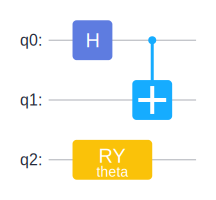

In [11]:
encoder.svg()

从对Encoder的Summary中可以看到，该量子线路由3个量子门组成，其中有1个含参量子门且参数为theta，该量子线路调控的量子比特数为3。

因此，我们可以根据自身所需求解的问题，搭建对应的量子线路。赶紧动手搭建属于你的第一个量子线路吧！

In [12]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')